# Composite Types and Objects

So far, we've worked with Julia's built-in types like `Int64`, `Float64`, and `Array`. Now, let's explore how to create our own custom types. This allows us to bundle related data together into a logical unit, a concept closely related to *object-oriented programming* in other languages.

## Composite Types with `struct`

We use the `struct` keyword to define a new **composite type**. Think of it as a blueprint for a new kind of data container. We give the type a name and define a list of **fields** (also called attributes), which are the variables that will hold the data for any object created from this blueprint.

Let's create a type named `MyPoly` to represent a polynomial. It will have two fields:
* `c`: A vector to store the polynomial's coefficients.
* `var`: A character to name the independent variable (like 'x' or 't').

You can also enforce the type of a field using the `::` operator. This is a great way to catch bugs early by ensuring your `struct` is always created with the correct data types. Here, we'll specify that `c` must be a `Vector` and `var` must be a `Char`.

In [1]:
# Define a new composite type (struct) for polynomials.
struct MyPoly
    # Field to store coefficients as a vector.
    c::Vector
    # Field for the variable name, e.g., 'x'.
    var::Char
end

We'll represent the polynomial in the standard monomial form, with the coefficients in the vector `c` ordered from the highest degree term to the lowest. 

For example, a polynomial $p(x) = c_d x^d + c_{d-1} x^{d-1} + \cdots + c_1 x + c_0$ would be stored with the coefficient vector `c` as `[c_d, c_{d-1}, ..., c_0]`.

The degree $d$ of the polynomial is simply `length(c) - 1`. This representation is convenient for many polynomial algorithms.

With our `MyPoly` blueprint defined, we can now create an **instance**, or an **object**, of this type. We do this by calling the type's name like a function and providing values for each field.

For example, to represent the polynomial $p(x) = 3x^2 - 5x + 2$, we would create an instance like this:

In [2]:
# Create an instance of MyPoly.
# This represents 3x^2 - 5x + 2.
p = MyPoly([3, -5, 2], 'x')

MyPoly([3, -5, 2], 'x')

By default, Julia just prints the type name and its field values. We'll learn how to create a prettier, custom display later!

### Creating Custom Constructors

Sometimes, you want more flexible ways to create objects. A **constructor** is a special function that initializes an object. Julia provides a default constructor, but you can add your own.

Let's say we want to create a `MyPoly` object by only providing the coefficients, assuming the variable is 'x' by default. We can define an **outer constructor** to handle this:

In [3]:
# This outer constructor provides a default value for the `var` field.
# It calls the original, inner constructor with 'x' as the second argument.
MyPoly(c) = MyPoly(c, 'x')

MyPoly

Right now, our `p` object just holds data. You can access the data in its fields using dot notation (`.`):

In [4]:
# Access the coefficient vector 'c'.
p.c

3-element Vector{Int64}:
  3
 -5
  2

In [5]:
# Access the variable character 'var'.
p.var

'x': ASCII/Unicode U+0078 (category Ll: Letter, lowercase)

### Immutability

By default, `struct`s in Julia are **immutable**, which means their field values cannot be changed after the object is created. This design choice can make code more predictable and safer. If you need to modify fields, you can define your type using `mutable struct` instead.

However, there's a crucial exception: if a field contains a **mutable** object (like our `Vector` `c`), you *can* change the *contents* of that object. You just can't make the field point to a completely different object.

For example, to change our polynomial to $p(x) = -x^3 + 3x^2 - 5x + 2$, you **cannot** reassign the `c` field directly:

```julia
# This will cause an error because MyPoly is immutable.
p.c = [-1, 3, -5, 2] 
```

But you **can** modify the contents of the *existing* vector `p.c`:

In [6]:
# First, resize the existing vector to make space for the new coefficients.
resize!(p.c, 4)
# Then, modify the contents of the vector in place.
p.c[1:4] = [-1, 3, -5, 2]
p

MyPoly([-1, 3, -5, 2], 'x')

Of course, a more common and often clearer approach in Julia is to simply create a new `MyPoly` instance with the updated values:

In [7]:
# Create a new polynomial object and re-bind the variable 'p' to it.
p = MyPoly([-1, 3, -5, 2], p.var)

MyPoly([-1, 3, -5, 2], 'x')

## Defining Behavior: Methods for Custom Types

We can define functions that operate on our new types. In Julia, a function that is specialized for a certain combination of argument types is called a **method**. This is a powerful feature that lets us define how generic operations (like `+` or `plot`) should behave for our specific type.

For example, let's define a function that multiplies a polynomial by its variable (e.g., turning $p(x)$ into $x \cdot p(x)$). This is equivalent to adding a zero coefficient at the end of our vector `c`.

In [8]:
# This function takes a polynomial and returns a new one.
function times_x(p)
    # vcat horizontally concatenates the vector p.c with a 0.
    return MyPoly(vcat(p.c, 0), p.var)
end

times_x(p)

MyPoly([-1, 3, -5, 2, 0], 'x')

### Type-Specific Methods

The `times_x` function above would work, but it's not very robust; it would fail if we passed it anything other than a `MyPoly`. A better practice is to specify the types of the arguments a function expects using the `::` operator. This creates a **method** that will only be called for arguments of that specific type.

Let's create a `degree` function that works specifically for `MyPoly` objects. The logic is to find the first non-zero coefficient (the leading coefficient) and calculate the degree from its position. We'll define the degree of the zero polynomial to be -1.

In [9]:
# This method of 'degree' is specialized for MyPoly objects.
function degree(p::MyPoly)
    # Find the index of the first non-zero coefficient.
    ix1 = findfirst(p.c .!= 0)
    if ix1 === nothing  # Check if all coefficients are zero.
        return -1
    else
        # The degree is the length of the vector minus the index of the leading term.
        return length(p.c) - ix1
    end
end

degree (generic function with 1 method)

In [10]:
# Test cases for our degree function.
println(degree(MyPoly([0, 0, 0, 0, 0]))) # Zero polynomial
println(degree(MyPoly([0, 0, 0, 0, 1]))) # Degree 0
println(degree(MyPoly([0, 0, 0, 1, 0]))) # Degree 1
println(degree(MyPoly([1, 0, 0, 0, 0]))) # Degree 4

-1
0
1
4


### Method Overloading

By specializing functions, we can define multiple methods for the same function name. This is called **method overloading**. Julia's *multiple dispatch* system automatically chooses the correct method to call based on the types of the arguments provided. This makes code highly readable and extensible. 🕺

In [11]:
# A new method for the 'degree' function that accepts an Int.
function degree(p::Int)
    println("degree function called with an Int argument.")
end

# A generic fallback method for any other type.
function degree(p)
    println("degree function called with a different argument type.")
end

# Julia's dispatch system will pick the correct method at runtime!
degree(1.234)             # Calls the generic method
degree([1, 2])            # Calls the generic method
degree(-123)              # Calls the Int-specific method
degree(MyPoly([1, 2, 3])) # Calls the MyPoly-specific method

degree function called with a different argument type.
degree function called with a different argument type.
degree function called with an Int argument.


2

## Customized Printing

Julia uses a generic function called `show` to control how objects are printed to the screen (or any other I/O stream). By overloading `Base.show` for our `MyPoly` type, we can create a much more user-friendly, mathematical representation.

The implementation below handles various special cases to format the polynomial correctly. The key takeaway is not the specific logic inside, but the concept that we are *extending* a function from Julia's `Base` library to teach it how to handle our new type.

In [12]:
# Extend the Base.show function to provide a custom display for MyPoly objects.
function Base.show(io::IO, p::MyPoly)
    d = degree(p)
    print(io, "MyPoly: ")
    if d < 0
        print(io, "0")
        return
    end
    for k = d:-1:0
        coeff = p.c[end-k]
        if coeff == 0 && d > 0
            continue
        end
        if k < d
            if isa(coeff, Real)
                if coeff > 0
                    print(io, " + ")
                else
                    print(io, " - ")
                end
                coeff = abs(coeff)
            else
                print(io, " + ")
            end
        end
        if isa(coeff, Real)
            print(io, coeff)
        else
            print(io, "($coeff)")
        end
        if k == 0
            continue
        end
        print(io, "⋅", p.var)
        if k > 1
            print(io, "^", k)
        end
    end
end

In [13]:
# Now when we display 'p', our custom 'show' method is called!
p

MyPoly: -1⋅x^3 + 3⋅x^2 - 5⋅x + 2

In [14]:
MyPoly([-1.234, 0, 0, 0, 4.321], 's')

MyPoly: -1.234⋅s^4 + 4.321

## Making Objects Behave Like Functions

A fundamental polynomial operation is evaluation: computing $p(x)$ for a given value $x$. We can implement this using the efficient **Horner's method**:

$$ p(x) = c_d x^d + c_{d-1} x^{d-1} + \cdots + c_0 = (\dots((c_d x + c_{d-1})x + c_{d-2})x + \cdots)x + c_0 $$

Instead of creating a new function like `evaluate(p, x)`, Julia allows us to make our `MyPoly` objects *callable*. This means we can treat an object `p` as if it were a function, using the syntax `p(x)` to evaluate it. This is achieved by defining a method with the special signature `function (::MyPoly)(...)`.

In [15]:
# This method makes MyPoly objects callable.
function (p::MyPoly)(x)
    # Start with the leading coefficient.
    val = p.c[1]
    # Apply Horner's method.
    for i in 2:length(p.c)
        val = val * x + p.c[i]
    end
    return val
end

In [16]:
# Now we can call our polynomial object like a function!
println(p(1))
println(p(1.234))

# Broadcasting works automatically for callable objects!
p.([1, -2, 1.3])

-1
-1.4808129039999995


3-element Vector{Float64}:
 -1.0
 32.0
 -1.6270000000000002

## Visualizing Polynomials: Extending `Plots.jl`

Thanks to our callable object, plotting a polynomial is now straightforward. We can extend the `plot` and `plot!` functions from the `Plots` package to work directly with `MyPoly` objects. This is another example of Julia's powerful composability. 📈

In [17]:
using Plots

# Extend Plots.plot! to add a MyPoly to an existing plot.
function Plots.plot!(p::MyPoly; xlim=[-2, 2])
    # Generate a range of x-values for a smooth curve.
    xx = range(xlim[1], xlim[2], length=100)
    # Use broadcasting p.(xx) to evaluate the polynomial at all points.
    plot!(xx, p.(xx), legend=false, grid=true, xlim=xlim)
    xlabel!(string(p.var))
end

# Extend Plots.plot to create a new plot for a MyPoly.
function Plots.plot(p::MyPoly; xlim=[-2, 2])
    # Create a new, empty plot.
    plot()
    # Call our new plot! method to add the polynomial.
    plot!(p; xlim=xlim)
end

MyPoly: 1⋅x^5 + 1⋅x^4 - 5⋅x^3 - 5⋅x^2 + 4⋅x + 4

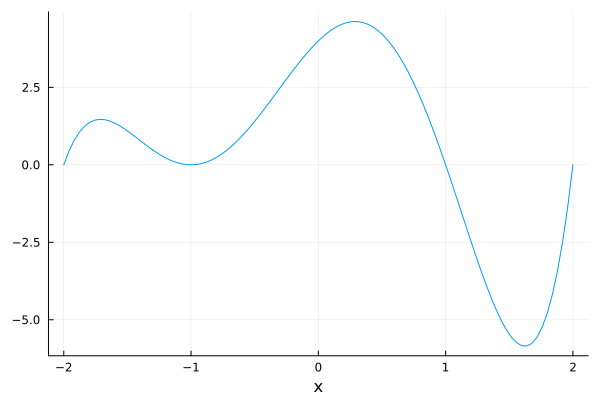

In [18]:
# Create a new polynomial for our plotting example.
p = MyPoly([1, 1, -5, -5, 4, 4])
display(p)

# It's now trivial to plot our object!
plot(p, xlim=[-2,2])

## Operator Overloading

Standard operators like `+`, `-`, and `*` are just functions in Julia. This means we can overload them for our `MyPoly` type, allowing us to write intuitive, mathematical expressions.

These fundamental operators belong to the `Base` module. When we extend a function from a module, we must qualify it with the module name, like `Base.:+`. (The colon `:` is needed because `+` is an operator).

To add two polynomials, we simply add their coefficients. The only trick is to first pad the shorter coefficient vector with zeros to make them the same length.

In [19]:
# Overload the addition operator for two MyPoly objects.
function Base.:+(p1::MyPoly, p2::MyPoly)
    # Ensure we're not adding polynomials of different variables.
    if p1.var != p2.var
        error("Cannot add polynomials with different independent variables.")
    end

    n1 = length(p1.c)
    n2 = length(p2.c)
    n = max(n1, n2)

    # Pad the shorter coefficient vector with leading zeros.
    c1_padded = [zeros(eltype(p1.c), n - n1); p1.c]
    c2_padded = [zeros(eltype(p2.c), n - n2); p2.c]

    return MyPoly(c1_padded + c2_padded, p1.var)
end

In [20]:
println(p)
println(p + p)
println(p + MyPoly([1.1, 2.2]))

# The following line will trigger our custom error message.
# println(p + MyPoly([1], 's'))

MyPoly: 1⋅x^5 + 1⋅x^4 - 5⋅x^3 - 5⋅x^2 + 4⋅x + 4
MyPoly: 2⋅x^5 + 2⋅x^4 - 10⋅x^3 - 10⋅x^2 + 8⋅x + 8
MyPoly: 1.0⋅x^5 + 1.0⋅x^4 - 5.0⋅x^3 - 5.0⋅x^2 + 5.1⋅x + 6.2


With addition defined, subtraction is easy! We can simply reuse our `+` operator.

In [21]:
# Overload the subtraction operator.
function Base.:-(p1::MyPoly, p2::MyPoly)
    # Subtraction is the same as adding the negation.
    return p1 + MyPoly(-p2.c, p2.var)
end

Scalar multiplication is similar. We can overload `*` to handle multiplying a polynomial by a number. Note that we don't specify the type of the scalar `a`, so it can be any kind of number. We also define multiplication in the reverse order to be commutative, simply by reusing the first method.

In [22]:
# Define scalar multiplication: number * polynomial.
function Base.:*(a, p::MyPoly)
    # Broadcasting the scalar multiplication across the coefficients.
    newc = a * p.c
    return MyPoly(newc, p.var)
end

# Define the reverse order: polynomial * number.
function Base.:*(p::MyPoly, a)
    # Reuse the method we just defined.
    return a * p
end

With our overloaded `+`, `-`, and `*` operators, we can now write clean, intuitive code to manipulate polynomials:

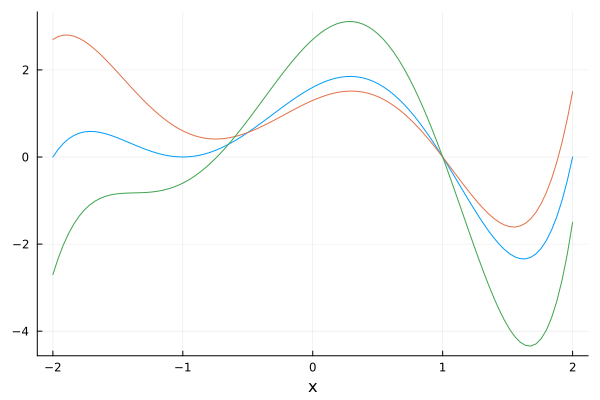

In [23]:
# Let's perform some arithmetic.
p1 = 0.4 * p
p2 = p1 - 0.3 * MyPoly([-2, 1, 1])
p3 = -1*p2 + p

# And plot the results!
plot()
plot!.([p1, p2, p3], xlim=[-2,2])
plot!()

## The Power of Generic Programming

Notice that in our `MyPoly` definition, we specified `c::Vector` but not `Vector{Float64}` or `Vector{Int}`. We left the *element type* of the vector generic. Because of this, all the functions we've written will automatically work for any numeric type that supports the basic operations (`+`, `*`, etc.).

This is a core design philosophy in Julia called **generic programming**. By not over-specifying types, we write flexible, reusable code that works for a wide range of inputs, including types we might not have even thought of.

For example, all our code works seamlessly with rational coefficients:

In [24]:
# Create a polynomial with rational coefficients.
p_rational = MyPoly([1, -2//3, 6//7])

MyPoly: 1//1⋅x^2 - 2//3⋅x + 6//7

In [25]:
# Our callable object method works perfectly.
p_rational.([1, -7//2])

2-element Vector{Rational{Int64}}:
   25//21
 1297//84

...and with complex numbers: ℂ

In [26]:
# A polynomial with complex coefficients.
p_complex = MyPoly([1, im, -1, -im, 1])

MyPoly: (1 + 0im)⋅x^4 + (0 + 1im)⋅x^3 + (-1 + 0im)⋅x^2 + (0 - 1im)⋅x + (1 + 0im)

In [27]:
# Evaluating it at complex points requires no code changes.
p_complex.([0, im, -1 - im])

3-element Vector{Complex{Int64}}:
  1 + 0im
  5 + 0im
 -2 + 1im

...and even with arbitrary-precision floats (`BigFloat`): 🔢

In [28]:
# Create a polynomial with standard Float64 coefficients.
p_float = MyPoly(-1.5:3.5)

MyPoly: -1.5⋅x^5 - 0.5⋅x^4 + 0.5⋅x^3 + 1.5⋅x^2 + 2.5⋅x + 3.5

In [29]:
# We can evaluate it with a BigFloat argument to get a high-precision result.
p_float(BigFloat(-π))

405.2722682884305251107738095974542912801020079018409933037640550322547603287204